In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pycaret.regression import *
from sklearn.metrics import r2_score

In [2]:
df=pd.read_csv("kc_house_data_NaN.csv")

In [3]:
df.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,7129300520,20141013T000000,221900.0,3.0,1.00,1180,5650,1.0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,6414100192,20141209T000000,538000.0,3.0,2.25,2570,7242,2.0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2,5631500400,20150225T000000,180000.0,2.0,1.00,770,10000,1.0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,3,2487200875,20141209T000000,604000.0,4.0,3.00,1960,5000,1.0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,4,1954400510,20150218T000000,510000.0,3.0,2.00,1680,8080,1.0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
df.iloc[df['price'].idxmin()]

Unnamed: 0                  1149
id                    3421079032
date             20150217T000000
price                    75000.0
bedrooms                     1.0
bathrooms                    NaN
sqft_living                  670
sqft_lot                   43377
floors                       1.0
waterfront                     0
view                           0
condition                      3
grade                          3
sqft_above                   670
sqft_basement                  0
yr_built                    1966
yr_renovated                   0
zipcode                    98022
lat                      47.2638
long                    -121.906
sqft_living15               1160
sqft_lot15                 42882
Name: 1149, dtype: object

### Data Wrangling

In [5]:
df.drop(['id', 'Unnamed: 0', 'date'], axis=1, inplace=True)

In [6]:
print("number of NaN values for the column bedrooms :", df['bedrooms'].isnull().sum())
print("number of NaN values for the column bathrooms :", df['bathrooms'].isnull().sum())

number of NaN values for the column bedrooms : 13
number of NaN values for the column bathrooms : 10


In [7]:
mean=df['bedrooms'].mean()
df['bedrooms'].replace(np.nan,mean, inplace=True)

In [8]:
mean=df['bathrooms'].mean()
df['bathrooms'].replace(np.nan,mean, inplace=True)

In [9]:
print("number of NaN values for the column bedrooms :", df['bedrooms'].isnull().sum())
print("number of NaN values for the column bathrooms :", df['bathrooms'].isnull().sum())

number of NaN values for the column bedrooms : 0
number of NaN values for the column bathrooms : 0


### Model Development

In [12]:
s=setup(
    df,
    target="price",
    log_experiment=True,
    experiment_name="House-sales-reg"
)

,Description,Value
0,Session id,2145
1,Target,price
2,Target type,Regression
3,Original data shape,"(21613, 19)"
4,Transformed data shape,"(21613, 19)"
5,Transformed train set shape,"(15129, 19)"
6,Transformed test set shape,"(6484, 19)"
7,Numeric features,18
8,Preprocess,True
9,Imputation type,simple


In [13]:
best = compare_models(sort="RMSE")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,68283.8220,15520823323.5220,123623.8675,0.8850,0.1721,0.1296,0.3110
rf,Random Forest Regressor,70229.9127,17420242925.5106,131378.6186,0.8703,0.1778,0.1314,9.3020
et,Extra Trees Regressor,70570.7516,18068921803.9319,133331.5850,0.8661,0.1803,0.1327,5.3660
gbr,Gradient Boosting Regressor,77949.3528,18495358435.8824,135285.3205,0.8623,0.1924,0.1489,2.3610
dt,Decision Tree Regressor,100646.1659,35198330834.5511,186561.0714,0.7377,0.2533,0.1867,0.1870
ridge,Ridge Regression,126408.0627,40531262047.3840,200730.3228,0.6977,0.4217,0.2566,0.0360
br,Bayesian Ridge,126408.3706,40531601404.5627,200731.1679,0.6977,0.4220,0.2566,0.0410
llar,Lasso Least Angle Regression,126431.8083,40531417532.3115,200731.1953,0.6977,0.4187,0.2567,0.0370
lasso,Lasso Regression,126431.8089,40531417530.5897,200731.1953,0.6977,0.4187,0.2567,0.3420
lr,Linear Regression,126432.9116,40531439513.5569,200731.2682,0.6977,0.4186,0.2567,1.4140


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

### Model plot

In [14]:
plot_model(best, plot="residuals_interactive")

    'data': [{'hovertemplate': 'Split=train<br>Predictions…

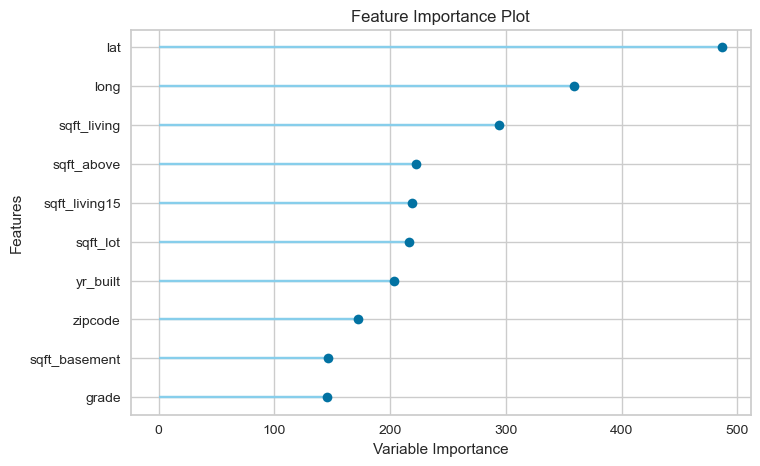

In [15]:
plot_model(best, plot="feature")

### Save best model

In [16]:
final_best = finalize_model(best)
final_best

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['bedrooms', 'bathrooms',
                                             'sqft_living', 'sqft_lot',
                                             'floors', 'waterfront', 'view',
                                             'condition', 'grade', 'sqft_above',
                                             'sqft_basement', 'yr_built',
                                             'yr_renovated', 'zipcode', 'lat',
                                             'long', 'sqft_living15',
                                             'sqft_lot15'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('actual_estimator',
                 LGBMRegressor(n_jobs=-1, random_state=2145))])

In [17]:
save_model(final_best, "House-sales-pipeline")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['bedrooms', 'bathrooms',
                                              'sqft_living', 'sqft_lot',
                                              'floors', 'waterfront', 'view',
                                              'condition', 'grade', 'sqft_above',
                                              'sqft_basement', 'yr_built',
                                              'yr_renovated', 'zipcode', 'lat',
                                              'long', 'sqft_living15',
                                              'sqft_lot15'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('actual_estimator',
                  LGBMRegressor(n_jobs=-1,

### Deployment

In [18]:
import mlflow
logged_model = 'runs:/104c063803224c30bf9a8c21f1f62130/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [21]:
df2=df.copy()
X=df2.drop(['price'], axis=1)
Y=df2['price']

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=1)

NameError: name 'Y' is not defined

In [24]:
# Predict on a Pandas DataFrame.
y_hat=loaded_model.predict(x_test)

In [25]:
y_hat

array([446294.44306757, 432518.58156294, 810201.87271573, ...,
       616938.3981819 , 692652.86227182, 323222.43889105])

In [31]:
r2_score(y_test,y_hat)

0.9163243623178474

### Refinement model

In [11]:
df3=df.copy()

In [12]:
X=df[['lat','long','sqft_living','yr_built','zipcode']]
y=df['price']

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [14]:
s1=setup(
    x_train,
    target=y_train,
    log_experiment=True,
    experiment_name="House-sales-reg2"
    )

,Description,Value
0,Session id,1690
1,Target,price
2,Target type,Regression
3,Original data shape,"(17290, 6)"
4,Transformed data shape,"(17290, 6)"
5,Transformed train set shape,"(12103, 6)"
6,Transformed test set shape,"(5187, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


In [15]:
best = compare_models(sort="RMSE")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,83017.7281,23773743479.8256,153105.5788,0.8109,0.2038,0.1529,0.2200
rf,Random Forest Regressor,84246.5336,25258826226.9334,157897.6305,0.7985,0.2067,0.1538,3.4550
et,Extra Trees Regressor,84854.3415,25281814544.3437,158008.5395,0.7979,0.2109,0.1561,2.4070
gbr,Gradient Boosting Regressor,92958.2763,27356433682.0104,164563.1512,0.7815,0.2244,0.1732,0.8120
dt,Decision Tree Regressor,114321.9961,46129500194.5718,214290.7612,0.6265,0.2799,0.2076,0.0760
br,Bayesian Ridge,145031.5346,51127560056.6522,225346.4508,0.5902,0.3888,0.2922,0.0280
ridge,Ridge Regression,145016.2107,51127723934.7956,225346.4605,0.5902,0.3889,0.2922,0.0250
llar,Lasso Least Angle Regression,145044.2188,51127536645.9854,225346.6810,0.5902,0.3891,0.2923,0.0270
lasso,Lasso Regression,145044.2198,51127536655.6563,225346.6810,0.5902,0.3891,0.2923,0.0220
lr,Linear Regression,145045.1206,51127536102.2999,225346.6979,0.5902,0.3891,0.2923,1.1860


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

In [16]:
final_best = finalize_model(best)
save_model(final_best, "House-sales-best-model")


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['lat', 'long', 'sqft_living',
                                              'yr_built', 'zipcode'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('actual_estimator',
                  LGBMRegressor(n_jobs=-1, random_state=1690))]),
 'House-sales-best-model.pkl')

In [20]:
# Create API -- pip install pycaret[mlops] --user
create_api(best, 'best_api_house_sales')

ModuleNotFoundError: 
'fastapi' is a soft dependency and not included in the pycaret installation. Please run: `pip install fastapi` to install.
Alternately, you can install this by running `pip install pycaret[mlops]`

In [40]:
final_best2 = finalize_model(best)
final_best2

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['lat', 'long', 'sqft_living',
                                             'yr_built', 'zipcode'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('actual_estimator',
                 RandomForestRegressor(n_jobs=-1, random_state=1123))])

In [41]:
save_model(final_best2, "House-sales-pipeline2")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['lat', 'long', 'sqft_living',
                                              'yr_built', 'zipcode'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('actual_estimator',
                  RandomForestRegressor(n_jobs=-1, random_state=1123))]),
 'House-sales-pipeline2.pkl')

### Deployment Final Model

In [17]:
import mlflow
logged_model2 = 'runs:/eb7837e28e314a6daa20bec1aeb2650d/model'

# Load model as a PyFuncModel.
loaded_model2 = mlflow.pyfunc.load_model(logged_model2)

In [47]:
# Predict on a Pandas DataFrame.
y_hat=loaded_model2.predict(x_test)

In [48]:
r2_score(y_test,y_hat)

0.8010340650755112

## Features descriptions :

| Variable      | Description                                                                                                 |
| ------------- | ----------------------------------------------------------------------------------------------------------- |
| sqft_living   | Square footage of the home                                                                                  |
| yr_built      | Built Year                                                                                                  |
| zipcode       | Zip code                                                                                                    |
| lat           | Latitude coordinate                                                                                         |
| long          | Longitude coordinate                                                                                        |



In [49]:
df['lat'].min()

47.1559

In [50]:
df['lat'].max()

47.7776

In [51]:
df['long'].min()

-122.519

In [52]:
df['long'].max()

-121.315

In [53]:
df['zipcode'].min()

98001

In [54]:
df['zipcode'].max()

98199

In [55]:
df['yr_built'].min()

1900

In [56]:
df['yr_built'].max()

2015

In [57]:
df['sqft_living'].min()

290

In [58]:
df['sqft_living'].max()

13540

In [60]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lat          21613 non-null  float64
 1   long         21613 non-null  float64
 2   sqft_living  21613 non-null  int64  
 3   yr_built     21613 non-null  int64  
 4   zipcode      21613 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 844.4 KB


In [76]:
summary={"Variable":["lat", "long", "sqft_living", "yr_built", "zipcode"],
    "Description":["Latitude coordinate", "Longitude coordinate", "Square footage of the home", "Built Year", "Zip code"],
    "Min_value":[df['lat'].min(), df['long'].min(), df['sqft_living'].min(), df['yr_built'].min(), df['zipcode'].min()],
    "Max_value":[df['lat'].max(), df['long'].max(), df['sqft_living'].max(), df['yr_built'].max(), df['zipcode'].max()]
    }

In [77]:
summary=pd.DataFrame(summary)
summary

,Variable,Description,Min_value,Max_value
0,lat,Latitude coordinate,47.1559,47.7776
1,long,Longitude coordinate,-122.5190,-121.3150
2,sqft_living,Square footage of the home,290.0000,13540.0000
3,yr_built,Built Year,1900.0000,2015.0000
4,zipcode,Zip code,98001.0000,98199.0000


In [19]:
lat = "47.2"
long = "-122.5190"
sqft = "500"
zipcode = "98050"
year = "1990"
x = pd.DataFrame([[float(lat), float(long), float(sqft), int(year), int(zipcode)]], columns=['lat', 'long', 'sqft_living', 'yr_built', 'zipcode'])

In [20]:
x

,lat,long,sqft_living,yr_built,zipcode
0,47.2,-122.519,500.0,1990,98050


In [33]:
int(loaded_model2.predict(x)[0])

366799

In [22]:
model = load_model('House-sales-best-model')

Transformation Pipeline and Model Successfully Loaded


In [34]:
def predict(lat, long, sqft, yr, zipcode):
    data = pd.DataFrame([[lat, long, sqft, yr, zipcode]])
    data.columns = ["lat", "long", "sqft_living", "yr_built", "zipcode"]

    predictions = predict_model(model, data=data) 
    return {
        "lat" : float(predictions['lat'][0]),
        "long" : float(predictions['long'][0]),
        "sqft_living" : int(predictions['sqft_living'][0]),
        "yr_built" : int(predictions['yr_built'][0]),
        "zipcode" : int(predictions['zipcode'][0]),
        "price": int(predictions['prediction_label'][0])}

In [35]:
predict(lat, long, sqft, zipcode, year)

{'lat': 47.2,
 'long': -122.519,
 'sqft_living': 500,
 'yr_built': 98050,
 'zipcode': 1990,
 'price': 294445}

### New Model Based on Features importance

In [10]:
important_features=["lat", "long", "sqft_living", "sqft_above", "sqft_living15", "sqft_lot15", "yr_built", "zipcode", "sqft_basement", "grade"]

In [11]:
new_df = df[important_features].copy()

In [12]:
new_df.head()

,lat,long,sqft_living,sqft_above,sqft_living15,sqft_lot15,yr_built,zipcode,sqft_basement,grade
0,47.5112,-122.257,1180,1180,1340,5650,1955,98178,0,7
1,47.7210,-122.319,2570,2170,1690,7639,1951,98125,400,7
2,47.7379,-122.233,770,770,2720,8062,1933,98028,0,6
3,47.5208,-122.393,1960,1050,1360,5000,1965,98136,910,7
4,47.6168,-122.045,1680,1680,1800,7503,1987,98074,0,8


In [13]:
y=df['price']

In [14]:
s=setup(data=new_df, target=y)

,Description,Value
0,Session id,7293
1,Target,price
2,Target type,Regression
3,Original data shape,"(21613, 11)"
4,Transformed data shape,"(21613, 11)"
5,Transformed train set shape,"(15129, 11)"
6,Transformed test set shape,"(6484, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


In [15]:
best = compare_models(sort="RMSE")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,74095.8718,20555526218.9134,142382.2447,0.8515,0.1842,0.1372,0.4540
rf,Random Forest Regressor,75254.6676,22080725967.9620,148097.9083,0.8384,0.1885,0.1384,8.8740
et,Extra Trees Regressor,76534.4833,22687251007.8052,150102.6003,0.8347,0.1925,0.1409,4.0180
gbr,Gradient Boosting Regressor,82914.5410,22949004095.2587,151275.3318,0.8309,0.2024,0.1552,2.3220
dt,Decision Tree Regressor,107105.1807,43733544914.4024,208422.4188,0.6759,0.2652,0.1939,0.2100
ridge,Ridge Regression,135877.0926,48117582210.6073,218485.2885,0.6518,0.4271,0.2769,0.0340
br,Bayesian Ridge,135875.3361,48117662003.2374,218485.4154,0.6518,0.4273,0.2769,0.0370
llar,Lasso Least Angle Regression,135894.8419,48117594442.6540,218485.8813,0.6518,0.4273,0.2770,0.0340
lasso,Lasso Regression,135894.8426,48117594462.6997,218485.8814,0.6518,0.4273,0.2770,0.2100
lr,Linear Regression,135895.6972,48117595795.9956,218485.8997,0.6518,0.4273,0.2770,1.9730


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

In [22]:
tuned_best = tune_model(best, optimize = 'RMSE', choose_better = True, fold=10, n_iter=500)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,70662.2473,18514056524.1909,136066.3681,0.8615,0.1782,0.1304
1,71784.0647,18239627026.4165,135054.1633,0.8696,0.1823,0.1308
2,73411.1166,22851638677.3854,151167.5847,0.8683,0.1751,0.1303
3,68193.0744,15772204531.8509,125587.4378,0.8502,0.1745,0.1312
4,68531.5819,13428526473.4524,115881.5191,0.8960,0.1698,0.1296
5,71719.7687,16427400870.9755,128169.4225,0.8693,0.1799,0.1335
6,73548.9156,23342399355.6851,152782.1958,0.8647,0.1797,0.1342
7,74146.2545,22892141695.6713,151301.4927,0.8229,0.1885,0.1363
8,71669.1299,17304686549.9907,131547.2788,0.8570,0.1814,0.1327


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


In [24]:
final_best = finalize_model(tuned_best)

In [25]:
save_model(final_best, "House-sales-10pred-tuned")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['lat', 'long', 'sqft_living',
                                              'sqft_above', 'sqft_living15',
                                              'sqft_lot15', 'yr_built',
                                              'zipcode', 'sqft_basement',
                                              'grade'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('actual_estimator',
                  LGBMRegressor(bagging_fraction=0.9, bagging_freq=5,
                                feature_fraction=1.0, min_child_samples=1,
                                min_split_gain=0.5, n_estimators=290, n_jobs=-1,
                                num_leaves=40, rando

In [66]:
new_df.iloc[df['price'].idxmin()]

lat                 47.2638
long              -121.9060
sqft_living        670.0000
sqft_above         670.0000
sqft_living15     1160.0000
sqft_lot15       42882.0000
yr_built          1966.0000
zipcode          98022.0000
sqft_basement        0.0000
grade                3.0000
Name: 1149, dtype: float64

In [67]:
df['price'].iloc[df['price'].idxmin()]

75000.0

In [27]:
y_hat=predict_model(final_best, data = new_df)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [30]:
r2_score(df['price'],y_hat['prediction_label'])

0.9600856643055452

In [31]:
new_df.iloc[30]

lat                 47.5391
long              -122.0700
sqft_living       2320.0000
sqft_above        2320.0000
sqft_living15     2580.0000
sqft_lot15        3980.0000
yr_built          2003.0000
zipcode          98027.0000
sqft_basement        0.0000
grade                8.0000
Name: 30, dtype: float64

In [32]:
df['price'].iloc[30]

580500.0